# Installing and importing libraries

In [1]:
pip install keras_nlp

In [2]:
pip install keras-applications

In [3]:
pip install np_utils

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.image as mp

# Loading the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
with open('/content/drive/My Drive/train/teltrain.txt') as file:
    traintel = file.read().split('\n')
with open('/content/drive/My Drive/train/engtrain.txt') as file:
    traineng = file.read().split('\n')
with open('/content/drive/My Drive/train/trainimages.txt') as file:
   trainimg = file.read().split('\n')

In [7]:
with open('/content/drive/My Drive/test/teltest.txt') as file:
    testtel = file.read().split('\n')
with open('/content/drive/My Drive/test/engtest.txt') as file:
    testeng = file.read().split('\n')
with open('/content/drive/My Drive/test/testimages.txt') as file:
   testimg = file.read().split('\n')

In [8]:
with open('/content/drive/My Drive/dev/teldev.txt') as file:
    devtel = file.read().split('\n')
with open('/content/drive/My Drive/dev/engdev.txt') as file:
    deveng = file.read().split('\n')
with open('/content/drive/My Drive/dev/devimages.txt') as file:
   devimg = file.read().split('\n')

In [9]:
#Vocab extra
engtxt = []
teltxt = []

with open('/content/drive/My Drive/engtel.txt') as file:
    for line in file:
        parts = line.split("++++$++++")
        if len(parts) == 2:
            engtxt.append(parts[0].strip())
            teltxt.append(parts[1].strip())

In [10]:
trvgg_feature=np.load('/content/drive/My Drive/trainfeature.npy', encoding='bytes')

In [11]:
trvgg_feature = np.concatenate((trvgg_feature[:13701], trvgg_feature[13751:17801], trvgg_feature[17811:]), axis=0)
#trvgg_feature = trvgg_feature[25001:]

In [12]:
dvgg_feature=np.load('/content/drive/My Drive/devfeature.npy', encoding='bytes')

In [13]:
ttvgg_feature=np.load('/content/drive/My Drive/testfeature.npy', encoding='bytes')

In [14]:
vgg_train_=trvgg_feature
vgg_val=dvgg_feature

# Text Data Preprocessing

## Make Sure data mappings are correct

### Train

In [15]:
print(len(traintel))
print(len(traineng))

28930
28929


In [16]:
traintel.pop()

''

In [17]:
print(len(traintel))
print(len(traineng))

28929
28929


In [18]:
print(traintel[-2])
print(traineng[-2])

ఇది ఒక గొర్రె
this is a sheep


In [19]:
#disinclude data discrepancies
traineng = traineng[:13701] + traineng[13751:17801] + traineng[17811:]
traintel = traintel[:13701] + traintel[13751:17801] + traintel[17811:]

### Test

In [20]:
print(len(testtel))
print(len(testeng))

1596
1595


In [21]:
testtel.pop()

''

In [22]:
print(len(testtel))
print(len(testeng))

1595
1595


In [23]:
print(testtel[0])
print(testeng[0])

నారింజ రంగు ట్రాఫిక్ కోన్
the orange coloured traffic cone	  


### Validation

In [24]:
print(len(devtel))
print(len(deveng))

998
999


In [25]:
deveng.pop()

''

In [26]:
print(len(devtel))
print(len(deveng))

998
998


In [27]:
print(devtel[10])
print(deveng[10])

ఎరుపు మరియు తెలుపు రైలు
a red and white train	   


## Data Cleaning

In [28]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r" ᠃", "", text)
    text = re.sub(r" ᠂", "", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"<5>", "5", text)
    text = re.sub(r"“ ", "", text)
    text = re.sub(r" ”", "", text)
    text = re.sub(r"[+\.\!\/_,$%^*(+\"\']+|[+——！，〈〉《》。︱？?、．％~@#￥%……&*（）’]", "", text)
    text=text.rstrip()
    return text

### Train

In [29]:
trainteldf = pd.DataFrame(traintel, columns=['Telugu'])
trainengdf = pd.DataFrame(traineng, columns=['English'])

In [30]:
traintelcl = trainteldf["Telugu"].apply(clean_text)
trainengcl = trainengdf["English"].apply(clean_text)
traintellist = list(traintelcl.values)
trainenglist = list(trainengcl.values)

In [31]:
#Extra vocabulary cleaning
engtxtdf = pd.DataFrame(engtxt, columns=['English'])
teltxtdf = pd.DataFrame(teltxt, columns=['Telugu'])

In [32]:
telcl = teltxtdf["Telugu"].apply(clean_text)
engcl = engtxtdf["English"].apply(clean_text)
teltxtlist = list(telcl.values)
engtxtlist = list(engcl.values)

### Validation

In [33]:
devteldf = pd.DataFrame(devtel, columns=['Telugu'])
devengdf = pd.DataFrame(deveng, columns=['English'])

In [34]:
devtelcl = devteldf["Telugu"].apply(clean_text)
devengcl = devengdf["English"].apply(clean_text)
devtellist = list(devtelcl.values)
devenglist = list(devengcl.values)

### Test

In [35]:
testteldf = pd.DataFrame(testtel, columns=['Telugu'])
testengdf = pd.DataFrame(testeng, columns=['English'])

In [36]:
testtelcl = testteldf["Telugu"].apply(clean_text)
testengcl = testengdf["English"].apply(clean_text)
testtellist = list(testtelcl.values)
testenglist = list(testengcl.values)

## Add start and end tokens to sentances

### Train

In [37]:
trtel_temp=[]
for s in traintellist:
    trtemp="sos "+s+" eos"
    trtel_temp.append(trtemp)
traintellist=trtel_temp
traintellist[1:5]

['sos కంప్యూటర్ స్క్రీన్\u200cలు ఆన్ చేయబడ్డాయి eos',
 'sos మనిషికి చిన్న జుట్టు ఉంది eos',
 'sos పెద్దల ఒడిలో తెరిచిన ఫోటో ఆల్బమ్ eos',
 'sos నల్ల కారు పక్కన అమ్మాయిల గుంపు ఉంది eos']

In [38]:
x_tr = trainenglist
y_tr = traintellist

In [39]:
print(len(trainenglist))

28869


In [40]:
# Extra Vocabulary
teltxt_temp=[]
for s in teltxtlist:
    txttemp ="sos "+s+" eos"
    teltxt_temp.append(txttemp)
teltxtlist=teltxt_temp
teltxtlist[1:5]

['sos టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు eos',
 'sos నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను eos',
 'sos టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడు సూపర్ మార్కెట్లోకి ప్రవేశించాడు eos',
 'sos పొగ గదిని నింపింది eos']

In [41]:
x_new = engtxtlist
y_new = teltxtlist

### Validation

In [42]:
dtel_temp=[]
for s in devtellist:
    dtemp="sos "+s+" eos"
    dtel_temp.append(dtemp)
devtellist=dtel_temp
devtellist[1:5]

['sos చాలా మాంసంతో కూడిన శాండ్\u200cవిచ్ వస్తువుల ముక్క eos',
 'sos పార్క్ దృశ్యం యొక్క నలుపు మరియు తెలుపు చిత్రం eos',
 'sos సింక్ మీద పెద్ద దీర్ఘచతురస్రాకార అద్దం eos',
 'sos విమానంలో ఆహారాన్ని లోడ్ చేస్తున్న కారు eos']

In [43]:
x_val = devenglist
y_val = devtellist

### Test

In [44]:
tttel_temp=[]
for s in testtellist:
    tttemp="sos "+s+" eos"
    tttel_temp.append(tttemp)
testtellist=tttel_temp
testtellist[1:5]

['sos ఒక స్టాప్ లైట్ eos',
 'sos అడవిలో మూడు జీబ్రాలు eos',
 'sos రోడ్డు పక్కన పార్క్ చేసిన కార్లు eos',
 'sos ఒక వ్యక్తి రైలులోకి ఎక్కుతున్నాడు eos']

In [45]:
x_tt = testenglist
y_tt = testtellist

## Find max sentance length

### Train

In [46]:
traintelwords = []
for i in traintellist:
    traintelwords.append(len(i.split()))

In [47]:
traintengwords = []
for j in trainenglist:
    traintengwords.append(len(j.split()))

In [48]:
trmaxlen_telugu = max(traintelwords)
trmaxlen_english = max(traintengwords)
print('Maximum sentence length-Telugu :',trmaxlen_telugu)
print('Maximum sentence length-English :',trmaxlen_english)

Maximum sentence length-Telugu : 17
Maximum sentence length-English : 16


### Validation

In [49]:
devtelwords = []
for i in devtellist:
    devtelwords.append(len(i.split()))

In [50]:
devengwords = []
for j in devenglist:
    devengwords.append(len(j.split()))

In [51]:
dmaxlen_telugu = max(devtelwords)
dmaxlen_english = max(devengwords)
print('Maximum sentence length-Telugu :',dmaxlen_telugu)
print('Maximum sentence length-English :',dmaxlen_english)

Maximum sentence length-Telugu : 11
Maximum sentence length-English : 13


### Test

In [52]:
testttelwords = []
for i in testtellist:
    testttelwords.append(len(i.split()))

In [53]:
testtengwords = []
for j in testtellist:
    testtengwords.append(len(j.split()))

In [54]:
ttmaxlen_telugu = max(testttelwords)
ttmaxlen_english = max(testtengwords)
print('Maximum sentence length-Telugu :',ttmaxlen_telugu)
print('Maximum sentence length-English :',ttmaxlen_english)

Maximum sentence length-Telugu : 13
Maximum sentence length-English : 13


## Tokenization

###  Train & Validation

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
x_tokens = Tokenizer()
x_tokens.fit_on_texts(x_tr + x_new)
x_tr = x_tokens.texts_to_sequences(x_tr)
x_val = x_tokens.texts_to_sequences(x_val)
print('x_tr:',x_tr)
print(len(x_tokens.word_index))
print('x_val:',x_val)

x_tr: [[17, 7, 61, 8165, 1079], [471, 6168, 501, 11], [54, 40, 627, 300], [775, 2226, 291, 11, 61, 2665, 2600], [57, 7, 5, 662, 10, 778, 1612, 3, 83, 103], [391, 9, 5, 3984], [454, 634, 10332], [221, 7, 882, 47], [57, 28, 713, 883, 11, 3, 221], [138, 1939, 3, 838], [15, 7, 61, 570, 8166], [630, 4198, 1499], [10333, 7, 11, 5, 189], [5, 47, 1526, 1262], [47, 2910, 823, 554, 2277], [132, 1541, 220, 26, 355], [54, 9, 560, 983, 1527, 11, 212], [236, 11, 3, 212], [5, 54, 255, 9, 756, 954], [1192, 676, 11, 221], [832, 10, 3, 555], [236, 10, 5, 483], [3, 1885, 7, 782], [5, 54, 514, 5, 174], [5, 132, 757, 9, 146], [955, 26, 3475, 1736], [899, 11, 3, 321], [5, 2431, 47, 321], [83, 511, 2326], [5, 132, 2096, 113, 9, 3, 1150, 10, 3, 103], [161, 103, 503, 706, 5, 220], [103, 11, 3, 220], [2486, 3111, 141, 10334], [5, 83, 103, 26, 5, 199, 225], [555, 37, 3, 189], [5, 8167, 356, 11, 5, 1182], [99, 873, 10, 5, 212], [236, 11, 5, 212], [171, 189, 255, 11, 366, 10, 5, 421], [421, 955, 7, 11], [5, 199, 1

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
y_tokens = Tokenizer()
y_tokens.fit_on_texts(y_tr + y_new)
y_tr = y_tokens.texts_to_sequences(y_tr)
y_val = y_tokens.texts_to_sequences(y_val)
print('x_tr:',y_tr)
print(len(y_tokens.word_index))
print('x_val:',y_val)

x_tr: [[1, 32, 23690, 11987, 2], [1, 455, 17452, 1026, 2039, 2], [1, 1277, 99, 247, 11, 2], [1, 10493, 4597, 2657, 792, 5830, 2], [1, 200, 91, 300, 7808, 2111, 11, 2], [1, 17453, 68, 428, 2], [1, 408, 596, 23691, 2], [1, 338, 413, 898, 375, 2], [1, 364, 663, 1027, 49, 2], [1, 7152, 2237, 68, 117, 2], [1, 10, 4396, 23692, 2], [1, 604, 17454, 2527, 2], [1, 23693, 3289, 25, 11, 2], [1, 79, 2002, 2470, 2], [1, 7153, 296, 1019, 4397, 764, 2], [1, 3474, 365, 4219, 30, 2], [1, 244, 81, 934, 136, 30, 541, 5831, 2], [1, 541, 224, 2], [1, 7, 30, 5283, 501, 170, 40, 2], [1, 364, 945, 1355, 2], [1, 683, 42, 971, 2], [1, 7, 489, 224, 2], [1, 23694, 2112, 55, 2], [1, 7, 30, 135, 1486, 2], [1, 420, 11988, 30, 2], [1, 14025, 7154, 891, 2], [1, 274, 25, 1133, 2], [1, 3475, 79, 274, 2], [1, 571, 1504, 5011, 2], [1, 7, 30, 91, 7155, 102, 14026, 2], [1, 143, 91, 303, 1181, 11, 2], [1, 303, 91, 2], [1, 23695, 136, 7809, 8510, 2], [1, 121, 81, 23696, 7, 886, 91, 2], [1, 141, 144, 683, 2], [1, 3607, 17455, 2

### Test

In [57]:
x_tt = x_tokens.texts_to_sequences(x_tt)
print('x_tt:',x_tt)
print(len(x_tokens.word_index))

x_tt: [[3, 356, 572, 2286], [5, 203, 250], [99, 977, 9, 3, 1695], [954, 503, 706, 3, 325, 10, 3, 332], [5, 54, 3143, 201, 5, 152], [15, 7, 5, 132], [464, 10, 224, 1300, 9, 5, 464], [1346, 46, 11, 5, 769], [5, 47, 464, 1129, 26, 2820], [132, 141, 5, 83, 352], [3, 434, 7, 83], [5, 259, 7, 255], [236, 11, 5, 212], [5, 11781, 7042, 290, 9, 3, 1214, 756, 108, 454, 1711], [3, 6363, 11, 3, 1577], [5, 189, 606, 10, 1205], [386, 10, 3, 674], [54, 141, 3016, 632], [5, 404, 10, 508], [5, 132, 387, 11, 5, 783], [15, 7, 5, 592], [600], [3249, 11, 3, 188], [5, 149, 1479, 73], [3, 259, 7, 514], [5, 665, 88, 146], [5, 259, 262, 213], [3, 412, 7, 31, 1263], [5, 102, 403, 11, 3, 783], [5, 233, 321, 4, 3, 346], [102, 250, 154, 26, 5, 83, 1037], [5, 146, 404, 11, 5, 189], [3017], [102, 103, 11, 3, 220], [57, 28, 99, 1001], [323, 40, 161, 751], [108, 100, 4849, 845], [7638, 1183, 11, 1182], [285, 386, 11, 212, 26, 1283, 11, 17], [386, 10, 5, 54, 26, 557], [5, 83, 367, 11, 3, 317], [115, 200, 197, 5, 519, 1

In [58]:
y_tt = y_tokens.texts_to_sequences(y_tt)

## Word Index

In [59]:
#English
x_tokens.index_word

{1: 'tom',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'a',
 6: 'you',
 7: 'is',
 8: 'that',
 9: 'in',
 10: 'of',
 11: 'on',
 12: 'do',
 13: 'was',
 14: 'he',
 15: 'this',
 16: 'me',
 17: 'it',
 18: 'mary',
 19: 'dont',
 20: 'have',
 21: 'and',
 22: 'for',
 23: 'know',
 24: 'we',
 25: 'my',
 26: 'with',
 27: 'what',
 28: 'are',
 29: 'im',
 30: 'be',
 31: 'his',
 32: 'want',
 33: 'didnt',
 34: 'not',
 35: 'think',
 36: 'your',
 37: 'at',
 38: 'like',
 39: 'did',
 40: 'has',
 41: 'can',
 42: 'go',
 43: 'how',
 44: 'were',
 45: 'she',
 46: 'about',
 47: 'white',
 48: 'will',
 49: 'here',
 50: 'very',
 51: 'its',
 52: 'all',
 53: 'why',
 54: 'man',
 55: 'going',
 56: 'time',
 57: 'there',
 58: 'they',
 59: 'had',
 60: 'told',
 61: 'an',
 62: 'him',
 63: 'tell',
 64: 'one',
 65: 'boston',
 66: 'said',
 67: 'cant',
 68: 'as',
 69: 'need',
 70: 'help',
 71: 'who',
 72: 'get',
 73: 'up',
 74: 'doesnt',
 75: 'her',
 76: 'ill',
 77: 'no',
 78: 'us',
 79: 'out',
 80: 'never',
 81: 'youre',
 82: 'from',
 83

In [60]:
#Telugu
y_tokens.index_word

{1: 'sos',
 2: 'eos',
 3: 'టామ్',
 4: 'నేను',
 5: 'మీరు',
 6: 'నాకు',
 7: 'ఒక',
 8: 'చాలా',
 9: 'నా',
 10: 'ఇది',
 11: 'ఉంది',
 12: 'ఈ',
 13: 'అతను',
 14: 'మీకు',
 15: 'మేము',
 16: 'మరియు',
 17: 'మీ',
 18: 'మేరీ',
 19: 'లేదు',
 20: 'తెలుసు',
 21: 'తన',
 22: 'ఆమె',
 23: 'ఏమి',
 24: 'అలా',
 25: 'మీద',
 26: 'గురించి',
 27: 'అని',
 28: 'కోసం',
 29: 'నన్ను',
 30: 'వ్యక్తి',
 31: 'తెలియదు',
 32: 'అది',
 33: 'చెప్పాడు',
 34: 'ఎందుకు',
 35: 'టామ్\u200cకు',
 36: 'నుండి',
 37: 'వారు',
 38: 'కాదు',
 39: 'సహాయం',
 40: 'ఉన్నాడు',
 41: 'ఇక్కడ',
 42: 'యొక్క',
 43: 'టామ్\u200cను',
 44: 'మాకు',
 45: 'ఆ',
 46: 'ఎప్పుడూ',
 47: 'ఎలా',
 48: 'ఉన్నారు',
 49: 'ఉన్నాయి',
 50: 'రోజు',
 51: 'ఇంకా',
 52: 'మేరీని',
 53: 'అనుకుంటున్నాను',
 54: 'ఇప్పుడు',
 55: 'ఉంటుంది',
 56: 'అవసరం',
 57: 'ఎక్కడ',
 58: 'మంచి',
 59: 'సమయం',
 60: 'ఫ్రెంచ్',
 61: 'ఇష్టం',
 62: 'ఉన్నాను',
 63: 'తిరిగి',
 64: 'పని',
 65: 'అనుకోను',
 66: 'దీన్ని',
 67: 'మేరీకి',
 68: 'ఉన్న',
 69: 'మిమ్మల్ని',
 70: 'అతని',
 71: 'నిజంగా',
 72: 'మా',
 73: '

## English to Teugu Word Dictionary

### English sentances

In [61]:
reverse_source_word_index=x_tokens.index_word
len(reverse_source_word_index)

16131

### Telugu sentances

In [94]:
target_word_index=y_tokens.word_index

In [98]:
reverse_target_word_index=y_tokens.index_word
len(reverse_target_word_index)

43174

## Padding sentances

In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [64]:
#train
x_tr = pad_sequences(x_tr,maxlen = trmaxlen_telugu,padding = 'post')
y_tr = pad_sequences(y_tr,maxlen = trmaxlen_telugu,padding = 'post')

In [65]:
#validation
x_val = pad_sequences(x_val,maxlen = trmaxlen_telugu,padding = 'post')
y_val = pad_sequences(y_val,maxlen = trmaxlen_telugu,padding = 'post')

In [66]:
#test
x_tt = pad_sequences(x_tt,maxlen = trmaxlen_telugu,padding = 'post')
y_tt = pad_sequences(y_tt,maxlen = trmaxlen_telugu,padding = 'post')

## Number of unique words

In [67]:
x_voc_size   =  len(x_tokens.word_index) +1
print("No of unique words in English",x_voc_size)

No of unique words in English 16132


In [68]:
x_voc=x_voc_size
x_voc

16132

In [69]:
y_voc_size   =  len(y_tokens.word_index) +1
print("No of unique words in English",y_voc_size)

No of unique words in English 43175


In [70]:
y_voc=y_voc_size
y_voc

43175

# Defining Model

### Encoder Parameters and Inputs

In [71]:
import keras_nlp
from keras.layers import Input, Embedding
#Model
x_voc=x_voc_size
y_voc=y_voc_size
latent_dim = 512
embedding_dim=512
batch_size  = None
#Encoder
encoder_inputs = Input(shape=(None,), name = 'text inputs')
#The model will take as input an integer matrix of size (batch,input_length)and the largest integer (i.e. word index) in the input
#enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#positional_encoding = np.zeros((1, trmaxlen_english, embedding_dim))  # Initialize positional encoding matrix

#for pos in range(trmaxlen_english):
#    for i in range(embedding_dim):
#        positional_encoding[0, pos, i] = np.sin(pos / (10000 ** (2 * i / embedding_dim)))

# Add positional encoding to the embedded sequence
#enc_emb = enc_tok + positional_encoding
enc_emb = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=x_voc,
    sequence_length=trmaxlen_telugu,
    embedding_dim=embedding_dim,
)(encoder_inputs)
print(encoder_inputs.shape)
print(enc_emb.shape)

(None, None)
(None, None, 512)


### Image Model

In [72]:
from keras.layers import Dense, RepeatVector, Concatenate, Reshape
from keras.models import Model
img_inputs=Input(shape=(4096,), name = 'image inputs')
d_1=Dense(512, activation='relu')(img_inputs)
r_1=RepeatVector(trmaxlen_telugu)(d_1)
p_1 = keras_nlp.layers.PositionEmbedding(trmaxlen_telugu)(r_1)
vf_model = Model(img_inputs, p_1)
vf_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image inputs (InputLayer)            │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 17, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ position_embedding                   │ (None, 17, 512)             │           8,704 │
│ (PositionEmbedding)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,106,368 (8.04 MB)

 Trainable params: 2,106,368 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

### FNet Encoder 1

In [73]:
import keras_nlp
encoder_output1 = keras_nlp.layers.FNetEncoder(intermediate_dim=64, name = 'EncoderLayer1')(enc_emb)

### Concatenation of image and text

In [74]:
encoder_output1 = Concatenate(axis=-1)([encoder_output1, p_1])
print(encoder_output1)

<KerasTensor shape=(None, None, 1024), dtype=float32, sparse=False, name=keras_tensor_5>


FNet Encoder 2

In [75]:
encoder_output3 = keras_nlp.layers.FNetEncoder(intermediate_dim=64, name = 'EncoderLayer2')(encoder_output1)
print(encoder_output3.shape)

(None, None, 1024)


### Encoder Model

In [76]:
encoder_model = Model(inputs=[encoder_inputs, img_inputs],outputs=[encoder_output3])
encoder_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image inputs (InputLayer) │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text inputs (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      2,097,664 │ image inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 512)      │      8,268,288 │ text inputs[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 17, 512)        │              0 │ dense[0][0]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderLayer1             │ (None, None, 512)      │         68,160 │ token_and_position_em… │
│ (FNetEncoder)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, 17, 512)        │          8,704 │ repeat_vector[0][0]    │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 1024)     │              0 │ EncoderLayer1[0][0],   │
│                           │                        │                │ position_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderLayer2             │ (None, None, 1024)     │        136,256 │ concatenate[0][0]      │
│ (FNetEncoder)             │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,579,072 (40.36 MB)

 Trainable params: 10,579,072 (40.36 MB)

 Non-trainable params: 0 (0.00 B)

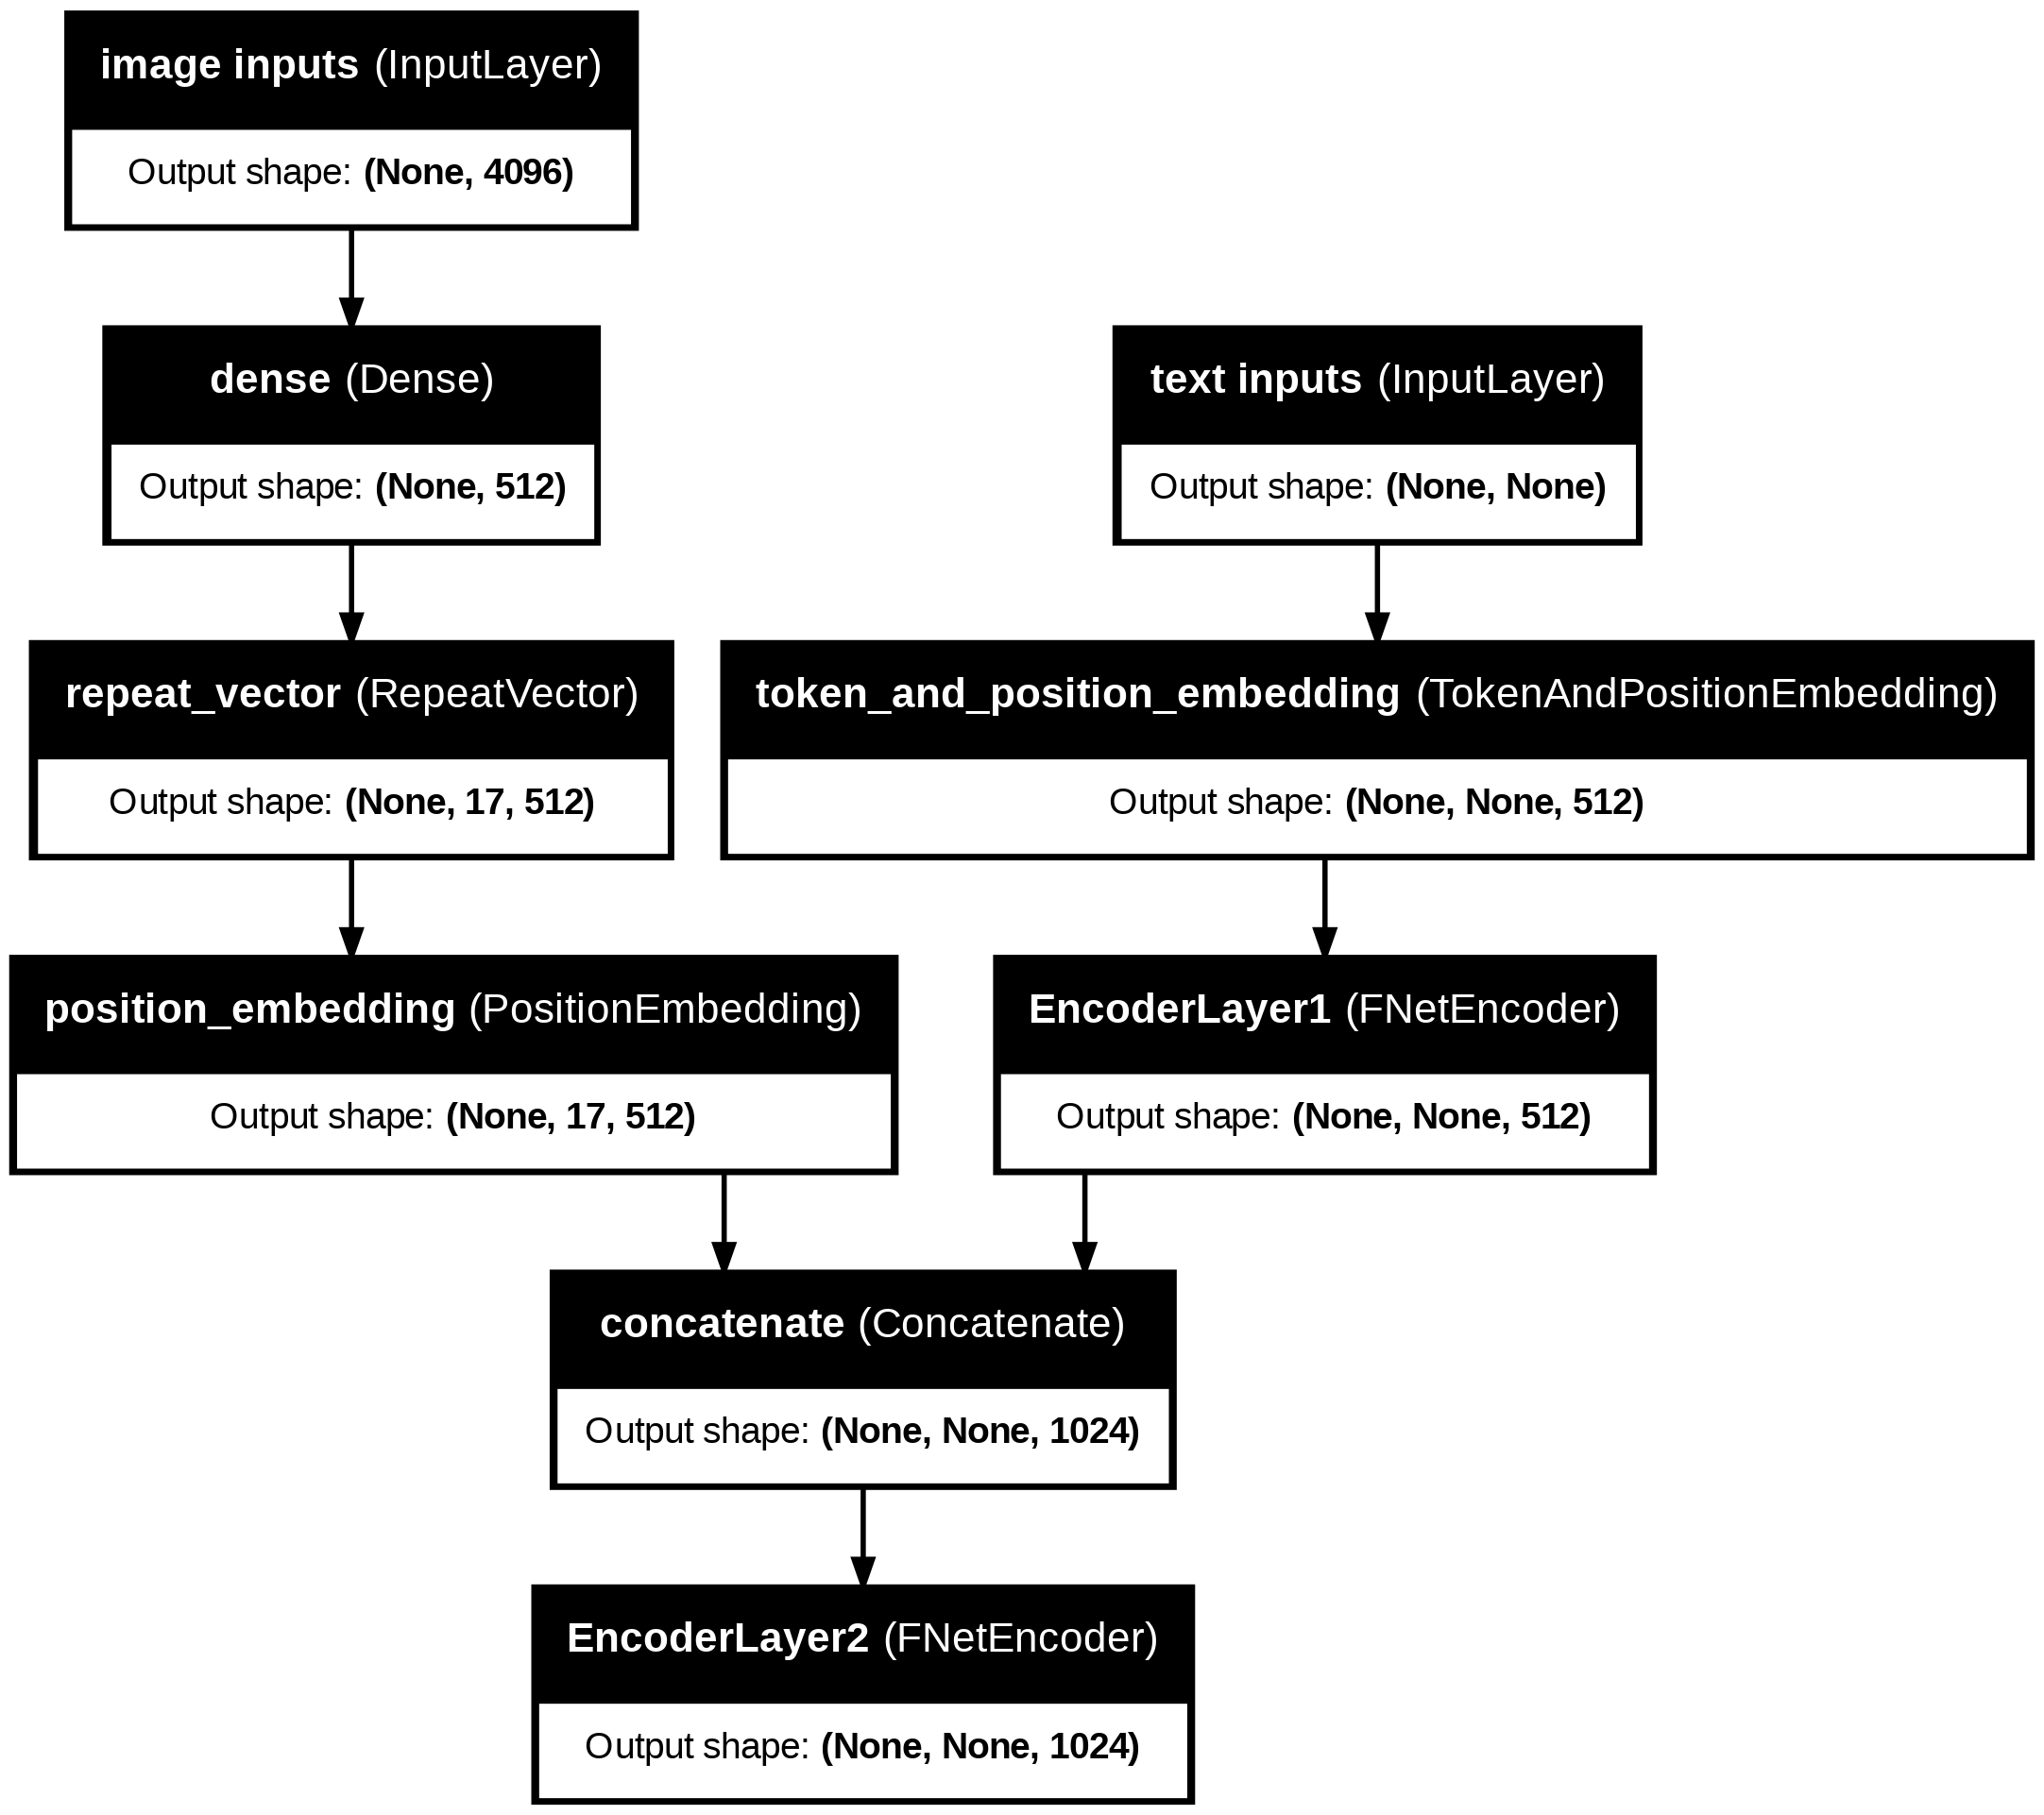

In [77]:
from keras.utils import plot_model
import tensorflow as tf
tf.keras.utils.plot_model(
    encoder_model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

### Decoder Parameters and Inputs

In [78]:
import keras
#Decoder
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name = 'Decoder input')
#embedding layer
#dec_emb = dec_emb_layer(decoder_inputs)
#positional_encoding = np.zeros((1, trmaxlen_english, embedding_dim))  # Initialize positional encoding matrix

#for pos in range(trmaxlen_english):
#    for i in range(embedding_dim):
#        positional_encoding[0, pos, i] = np.sin(pos / (10000 ** (2 * i / embedding_dim)))

# Add positional encoding to the embedded sequence
#dec_emb = dec_tok + positional_encoding

dec_emb = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=y_voc,
    sequence_length=trmaxlen_telugu,
    embedding_dim=embedding_dim,
)(decoder_inputs)
print(decoder_inputs.shape)
print(dec_emb.shape)
encoded_seq_inputs = keras.Input(shape=(None, 1024), name="decoder_state_inputs")

(None, None)
(None, None, 512)


### Transformer Decoder layer 1

In [79]:
import keras_nlp
import keras
decoder_layer = keras_nlp.layers.TransformerDecoder(intermediate_dim=64, num_heads=8)
x = decoder_layer(decoder_sequence = dec_emb, encoder_sequence = encoded_seq_inputs)
#x = keras.layers.Dropout(0.5)(x)

### Dense layer Output

In [80]:
decoder_outputs = keras.layers.Dense(y_voc, activation="softmax")(x)

In [81]:
print(decoder_outputs.shape)

(None, None, 43175)


### Decoder Model

In [82]:
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_output3])
decoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Decoder input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 512)      │     22,114,304 │ Decoder input[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_state_inputs      │ (None, None, 1024)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ (None, None, 512)      │      2,694,720 │ token_and_position_em… │
│ (TransformerDecoder)      │                        │                │ decoder_state_inputs[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 43175)    │     22,148,775 │ transformer_decoder[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 46,957,799 (179.13 MB)

 Trainable params: 46,957,799 (179.13 MB)

 Non-trainable params: 0 (0.00 B)

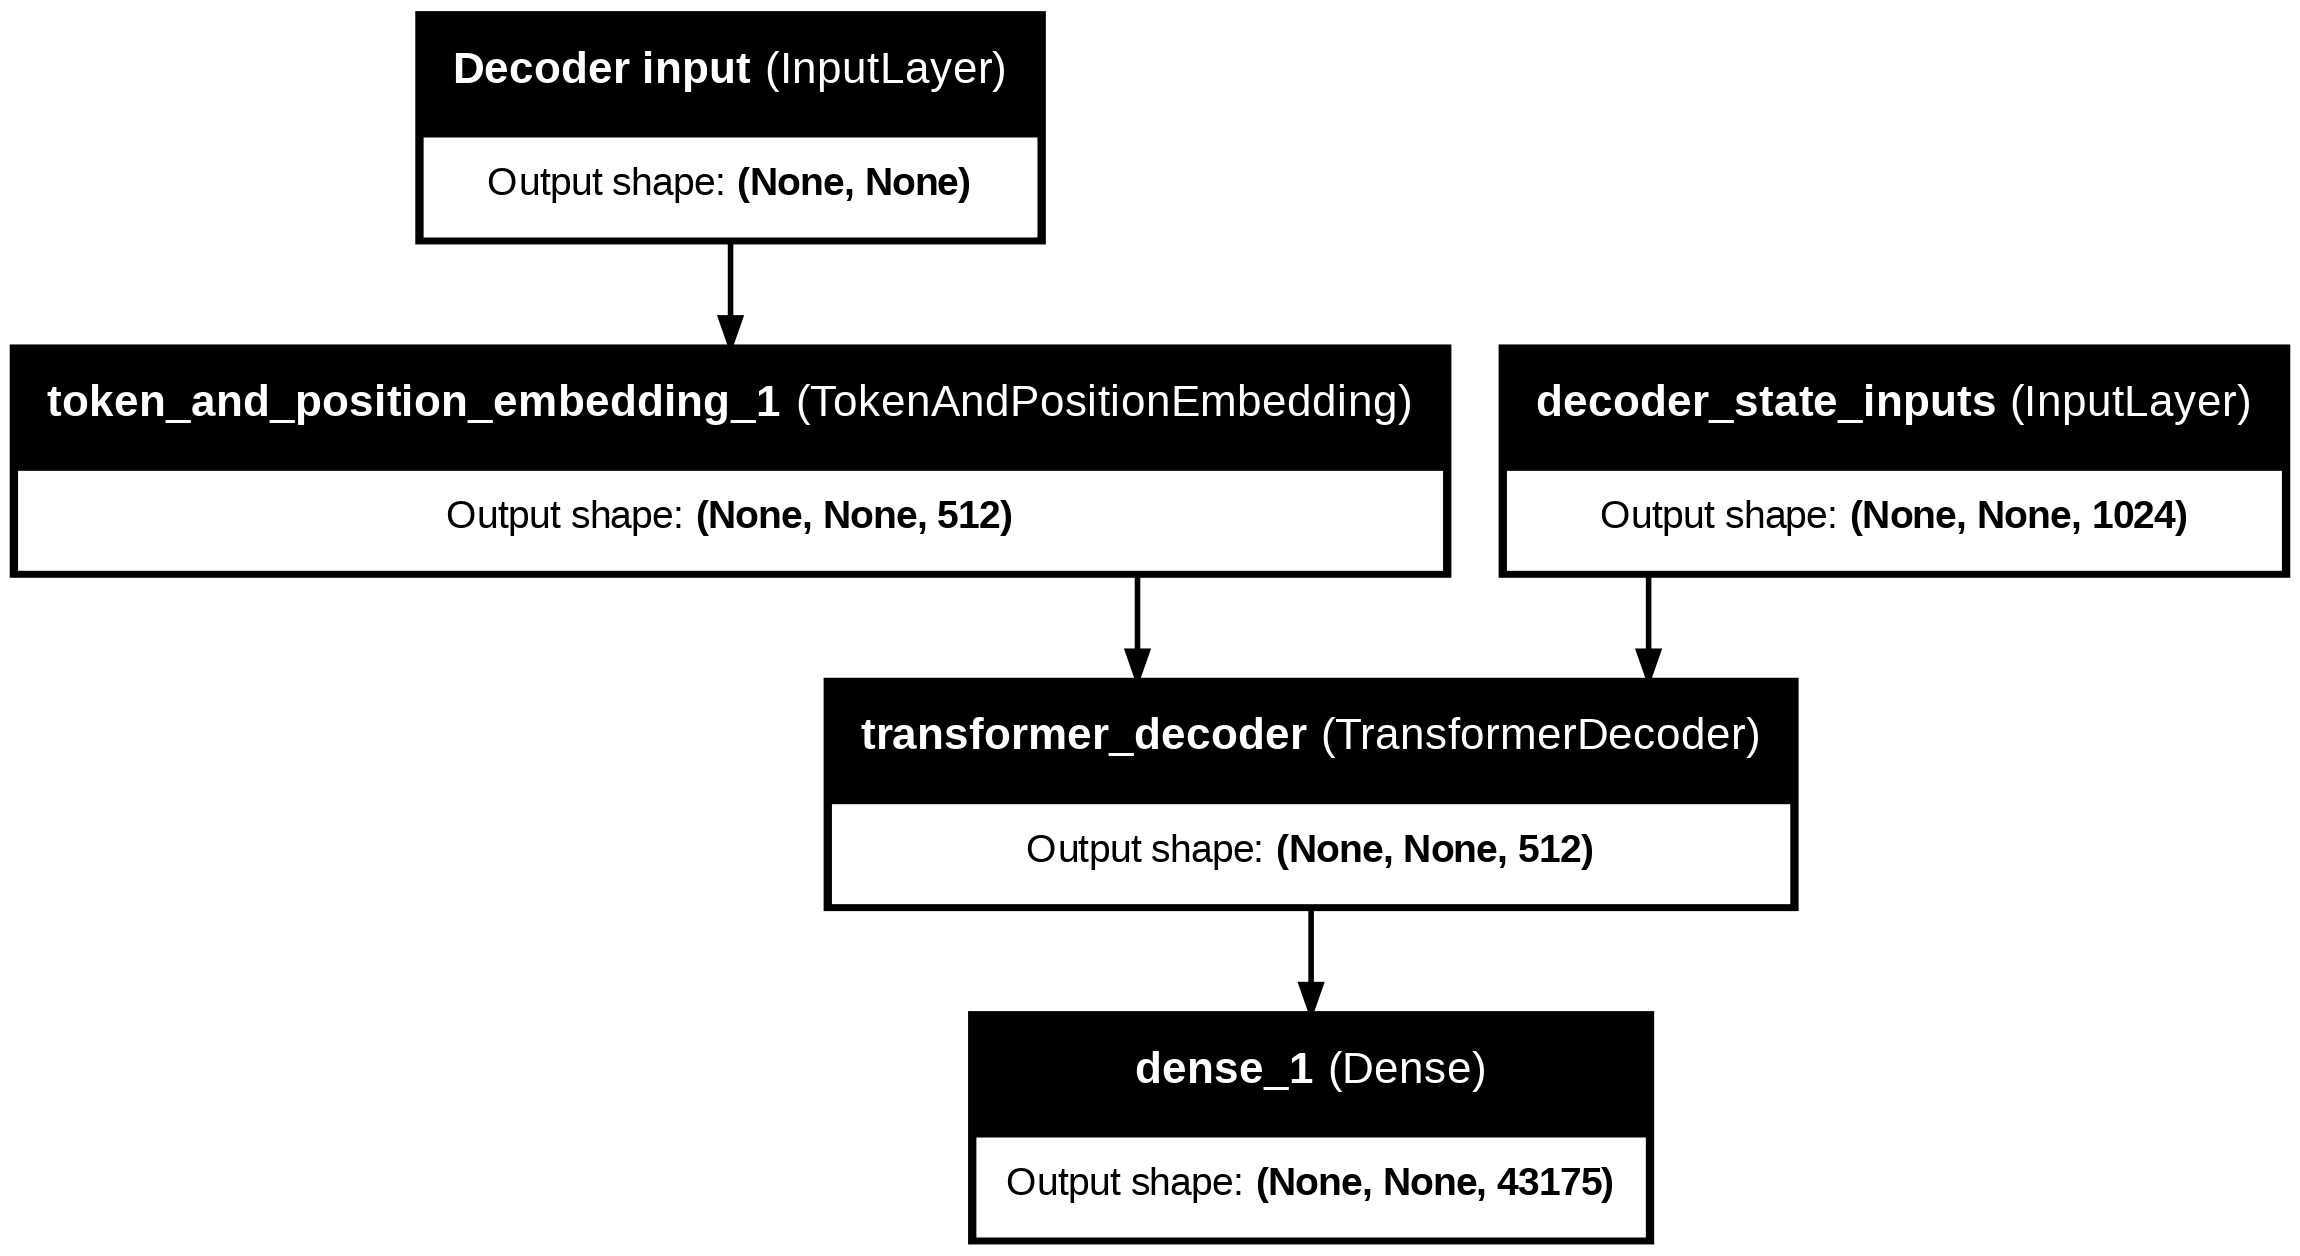

In [83]:
from keras.utils import plot_model
import tensorflow as tf
tf.keras.utils.plot_model(
    decoder,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

### Final Model Architecture

In [84]:
transformer = keras.Model(
    [encoder_inputs, decoder_inputs, img_inputs],
    decoder_outputs,
    name="transformer",
)

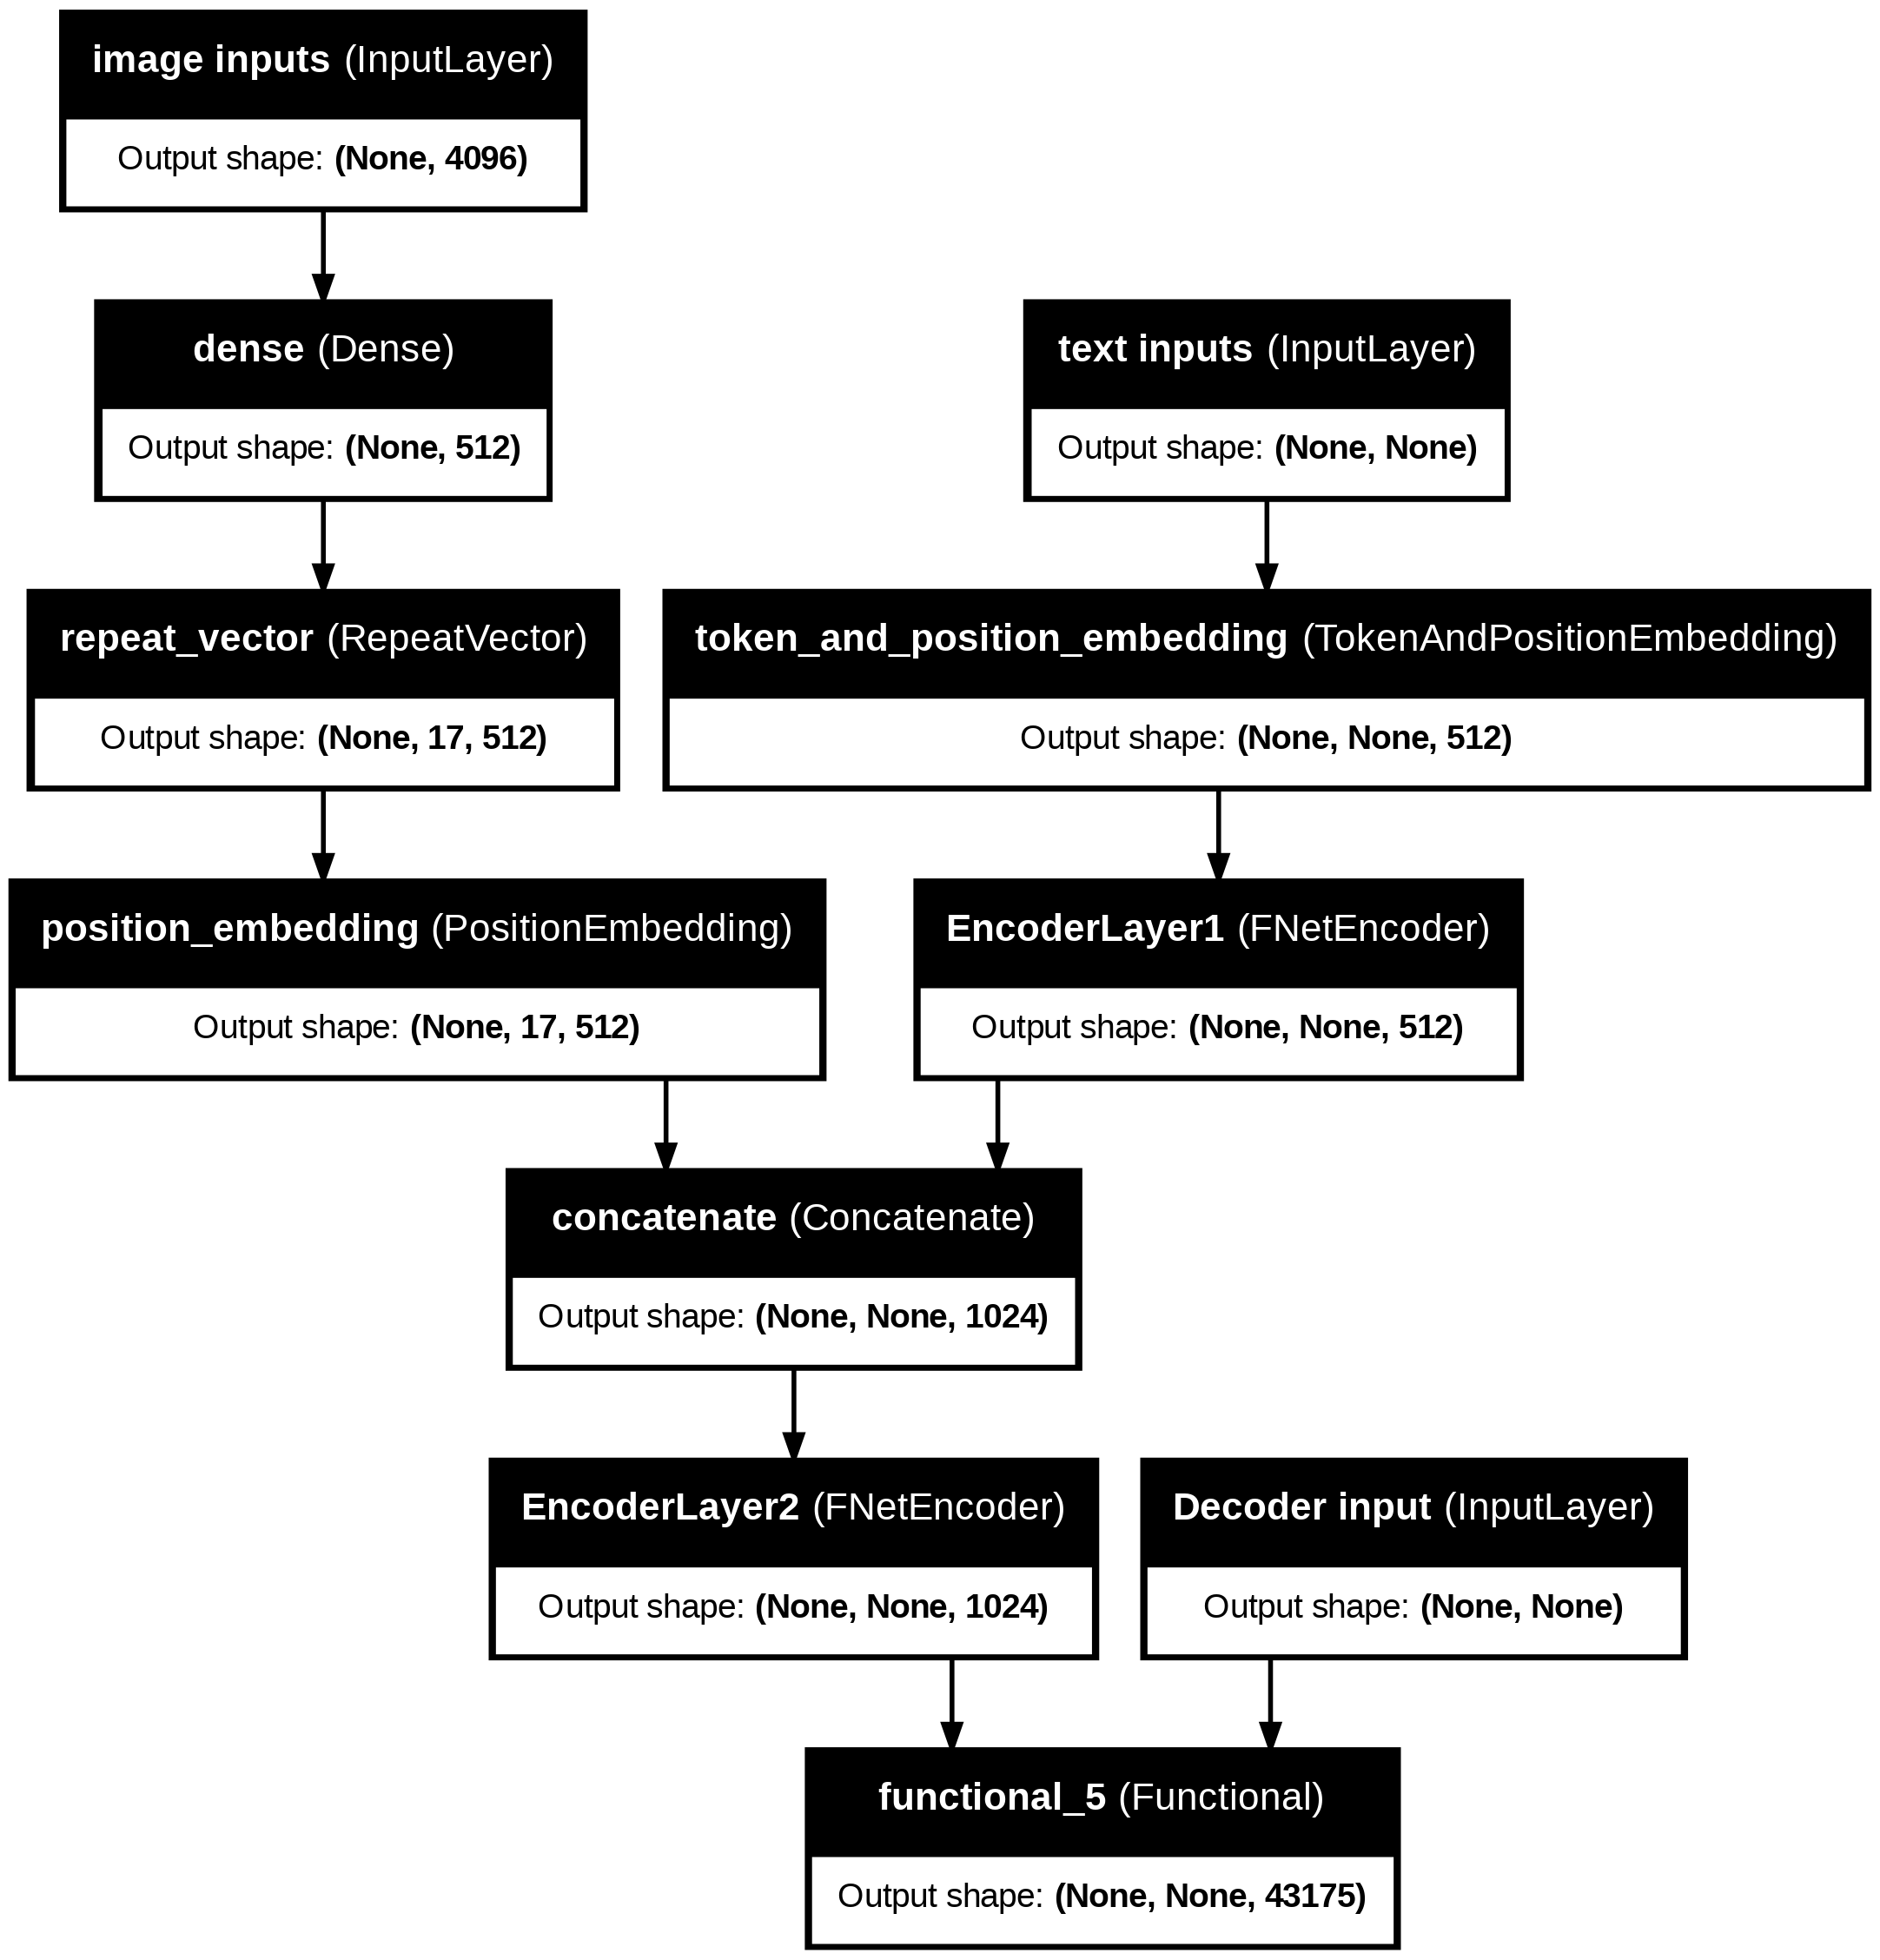

In [85]:
from keras.utils import plot_model
import tensorflow as tf
tf.keras.utils.plot_model(
    transformer,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

# Training the model

## Checkpoint

In [86]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("Telugu/modelnmtattention.keras", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

## Shapes of training and validation data

In [87]:
print("Shape of x_tr:", x_tr.shape)
print("Shape of y_tr:", y_tr.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print(len(x_tokens.word_index))
print(len(y_tokens.word_index))
print(x_voc)
print(y_voc)

Shape of x_tr: (28869, 17)
Shape of y_tr: (28869, 17)
Shape of x_val: (998, 17)
Shape of y_val: (998, 17)
16131
43174
16132
43175


## Compile Model

In [88]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## Train model

In [89]:
history=transformer.fit([x_tr,y_tr[:,:-1], vgg_train_], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,validation_data=([x_val,y_val[:,:-1], vgg_val], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),epochs=8,batch_size=512)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 889ms/step - accuracy: 0.6770 - loss: 4.2418 - val_accuracy: 0.8099 - val_loss: 1.3343
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.8089 - loss: 1.2870 - val_accuracy: 0.8330 - val_loss: 1.1004
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - accuracy: 0.8459 - loss: 0.9341 - val_accuracy: 0.8808 - val_loss: 0.7987
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - accuracy: 0.9056 - loss: 0.5342 - val_accuracy: 0.9062 - val_loss: 0.6044
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 464ms/step - accuracy: 0.9422 - loss: 0.2845 - val_accuracy: 0.9173 - val_loss: 0.5201
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 463ms/step - accuracy: 0.9670 - loss: 0.1551 - val_accuracy: 0.9222 - val_loss: 0.4849
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 462ms/step - accuracy: 0.9801 - loss: 0.0904 - val_accuracy: 0.9260 - val_loss: 0.4631
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 462ms/step - accuracy: 0.9870 - loss: 0.0556 - val_accuracy: 0.9242 - val

## Save the model

In [90]:
transformer.save("modelfnet.keras")

# Getting Translations

## Beam Search Sampling Function

In [99]:
import numpy as np

def beam_search_decode_sequence(input_seq, img, beam_size):
    img = img[np.newaxis, :]
    e_out = encoder_model.predict([input_seq, img])

    # Initialize the first target sequence with the start token
    start_token_index = target_word_index['sos']
    first_target_seq = np.array([[start_token_index]])

    # Initialize the list of completed sequences
    completed_sequences = []

    # Initialize the list of sequences to consider
    sequences = [[first_target_seq, 0.0]]

    # Start decoding
    while sequences:
        new_sequences = []
        for seq, score in sequences:
            # Get the last token in the sequence
            last_token = seq[:, -1]

            # If the last token is the end token or the sequence reaches the maximum length, mark it as completed
            if last_token == target_word_index['eos'] or len(seq[0]) >= (trmaxlen_telugu - 1):
                completed_sequences.append([seq, score])
                continue

            # Generate the next token probabilities
            output_tokens = decoder.predict([seq, e_out])

            # Get the top-k tokens
            top_k_indices = np.argsort(output_tokens[0, -1, :])[-beam_size:]

            # Expand the sequences with each possible next token
            for token_index in top_k_indices:
                next_seq = np.append(seq, [[token_index]], axis=1)
                new_score = score - np.log(output_tokens[0, -1, token_index] + 1e-8)
                new_sequences.append([next_seq, new_score])

        # Sort the new sequences by score
        new_sequences.sort(key=lambda x: x[1])

        # Select the top-k sequences to continue decoding
        sequences = new_sequences[:beam_size]

    # Select the best completed sequence
    best_seq, _ = min(completed_sequences, key=lambda x: x[1])

    # Convert the sequence of token indices into words
    decoded_sentence = ' '.join(reverse_target_word_index[index] for index in best_seq[0] if index != 0)
    return decoded_sentence

## English and telugu sentance returning functions

In [100]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Printing Translations

In [108]:
print("Review:",seq2text(x_tt[948]))
print("Original summary:",seq2summary(y_tt[948]))
print("Predicted summary:",beam_search_decode_sequence(x_tt[948].reshape(1,trmaxlen_telugu),ttvgg_feature[948], 3))
print("\n")

Review: batter in a blue jersey 
Original summary: నీలిరంగు కొట్టు 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

In [101]:
for i in range(10):
    print("Review:",seq2text(x_tt[i]))
    print("Original summary:",seq2summary(y_tt[i]))
    print("Predicted summary:",beam_search_decode_sequence(x_tt[i].reshape(1,trmaxlen_telugu),ttvgg_feature[i], 3))
    print("\n")

Review: the orange traffic cone 
Original summary: నారింజ రంగు ట్రాఫిక్ కోన్ 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

# Calculating Bleu score

In [102]:
 pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00


In [113]:
 import sacrebleu
 import random
temp_o=[]
temp_p=[]
for i in [0,1500]:
    s=random.randint(0,len(y_tt)-1)
    temp_o2.append(seq2summary(y_tt[s]))
    temp_p2.append(beam_search_decode_sequence(x_tt[s].reshape(1,trmaxlen_telugu), ttvgg_feature[s], 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [121]:
bleu = sacrebleu.corpus_bleu(temp_o2, [temp_p2],lowercase=True, tokenize='intl')
print(bleu.score)

64.11803884299549
